In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We want our plots to appear inside the notebook
%matplotlib inline 

# Models from Sckit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
df = pd.read_csv("../input/heart-disease-cleveland-uci/heart_cleveland_upload.csv")
df.shape #(rows, columns)

(297, 14)

## 5: Modeling
​
We have done some EDA on data. We have found some correlations but let's see if we can refine this.
​
We can do a Data Driven EDA, modeling a machine to find patterns between the data.
​
This is a **classification** problem with only two classes (0 = No disease, 1 = Disease).
​
We are going to try some different models from `Scikit-Learn` library, follwing this model map:
* https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [3]:
# Creating X and y
X = df.drop("condition", axis = 1)
y = df["condition"]

# Splitting the data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [4]:
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()

X_train_std = sclr.fit_transform(X_train)
X_test_std = sclr.transform(X_test)

In [5]:
models = {"Logistic Regression": LogisticRegression(),
          "Random Forest Classifier": RandomForestClassifier(),
          "KNN": KNeighborsClassifier()}

# Define a function to fit and score our models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels) 
    y_train : training labels
    y_test : test labels
    """
    # Setup random seed
    np.random.seed(42)
    
    # Setup an empty dictionary to record scores 
    model_scores = {}
    
    # Iterating over models
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        # Scoring the model and update model_scores
        model_scores[name] = model.score(X_test, y_test)
    
    return model_scores

In [6]:
model_scores = fit_and_score(models,
                             X_train = X_train_std,
                             X_test = X_test_std,
                             y_train = y_train,
                             y_test = y_test)

model_scores

{'Logistic Regression': 0.8333333333333334,
 'Random Forest Classifier': 0.8333333333333334,
 'KNN': 0.8166666666666667}

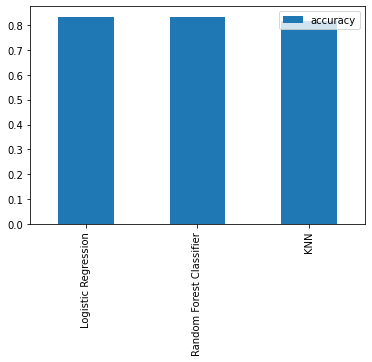

In [7]:
model_compare = pd.DataFrame(model_scores, index = ["accuracy"])
model_compare.T.plot.bar();

In [8]:
train_scores = []
test_scores = []

n_neighbors = range(1, 21)

# Setup KNN
knn = KNeighborsClassifier()

for i in n_neighbors:
    knn.set_params(n_neighbors = i)
    
    # Fit the model
    knn.fit(X_train_std, y_train)
    
    # Score the model
    train_scores.append(knn.score(X_train_std, y_train))
    test_scores.append(knn.score(X_test_std,y_test))

The best accuracy score with KNN, after tuning, is: 85.00%
with the optimal number of neighbors: 7


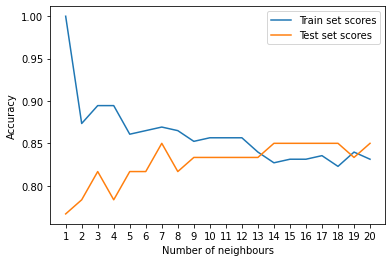

In [9]:
plt.plot(n_neighbors, train_scores, label = " Train scores")
plt.plot(n_neighbors, test_scores, label = "Test scores")
plt.xticks(range(1, 21, 1))
plt.xlabel("Number of neighbours")
plt.ylabel("Accuracy")
plt.legend(["Train set scores", "Test set scores"]);

print(f"The best accuracy score with KNN, after tuning, is: {max(test_scores)*100:.2f}%")
print(f"with the optimal number of neighbors: {test_scores.index(max(test_scores))+1}")

In [10]:
n_estimators = range(10, 1000, 10)
max_depth = range(10, 100, 10)
params ={"n_estimators": n_estimators,
         "max_depth": max_depth ,
         "min_samples_split": [2, 5, 10],
         "min_samples_leaf": [1, 2, 4],
         "bootstrap": [True, False]}
rf = RandomForestClassifier(random_state = 42)

#Set up RandomizesSearchCV
rs_rf = RandomizedSearchCV(estimator = rf,
                           param_distributions = params, 
                           scoring = "accuracy",
                           n_iter = 10,
                           n_jobs = -1,
                           cv = 5,
                           verbose = True)

# Fit the model with RSCV
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': range(10, 100, 10),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': range(10, 1000, 10)},
                   scoring='accuracy', verbose=True)

In [11]:
rs_rf.score(X_test, y_test), rs_rf.best_params_

(0.8333333333333334,
 {'n_estimators': 530,
  'min_samples_split': 2,
  'min_samples_leaf': 2,
  'max_depth': 80,
  'bootstrap': False})

In [12]:
# Creating a PipeLine to avoid data leakage from Standardization
from sklearn.pipeline import Pipeline
pipe = Pipeline([("sclr", StandardScaler()), # StandardScaler 
                 ("lr", LogisticRegression()) #RandomForestClassifier
                ])

# Creating a dict of hyperparameters to tune

params ={"lr__C": [100, 10, 1, 0.1, 0.01],
         "lr__solver": ["liblinear"],
         "lr__penalty": ["l2"]
        }

#Set up RandomizesSearchCV
rs_lr = RandomizedSearchCV(estimator = pipe,
                           param_distributions = params, 
                           scoring = "accuracy",
                           n_iter = 5,
                           n_jobs = -1,
                           cv = 5,
                           verbose = True)

# Fit the model with RSCV
rs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sclr', StandardScaler()),
                                             ('lr', LogisticRegression())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'lr__C': [100, 10, 1, 0.1, 0.01],
                                        'lr__penalty': ['l2'],
                                        'lr__solver': ['liblinear']},
                   scoring='accuracy', verbose=True)

In [13]:
rs_lr.score(X_test, y_test)

0.9

In [14]:
# Setup our KNN model with best params and make some predictions
knn_tuned = KNeighborsClassifier(n_neighbors = 11)

knn_tuned.fit(X_train_std, y_train)
y_preds = knn_tuned.predict(X_test_std);

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


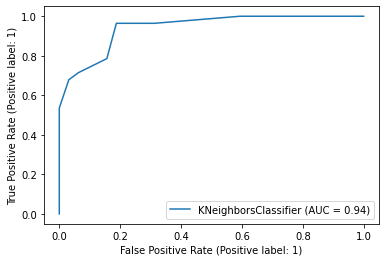

In [15]:
# Plotting ROC curve and calculate AUC
plot_roc_curve(knn_tuned, X_test_std, y_test)

In [16]:
# Print Confusion Matrix
confusion_matrix(y_preds, y_test)

array([[30,  8],
       [ 2, 20]])

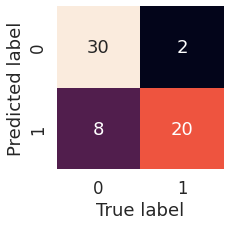

In [17]:
# Visualize confusion matrix with sns Heatmap
sns.set(font_scale = 1.5)

# Define a function to plot our confusion matrix 
def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap
    """
    fig, ax = plt.subplots(figsize = (3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot = True,
                     cbar = False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
plot_conf_mat(y_test, y_preds)

In [18]:
# Print classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        32
           1       0.91      0.71      0.80        28

    accuracy                           0.83        60
   macro avg       0.85      0.83      0.83        60
weighted avg       0.85      0.83      0.83        60

